In [1]:
from copy import copy
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet152, ResNet152_Weights

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
from tqdm import tqdm
from torchvision.models.resnet import Bottleneck

In [2]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
                      else "cpu")

weights_default = ResNet152_Weights.DEFAULT

In [3]:
device

device(type='cuda')

In [4]:
model = resnet152(weights=weights_default).to(device)
base_model = copy(model)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 131MB/s]


#**Task 1. Baseline Setup**

##1.1 Freezing the Backbone

In [ ]:
num_classes = 10
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes).to(device)
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for i, p in enumerate(base_model.parameters()):
  print(f"{i + 1}: {p.shape}")


1: torch.Size([64, 3, 7, 7])
2: torch.Size([64])
3: torch.Size([64])
4: torch.Size([64, 64, 1, 1])
5: torch.Size([64])
6: torch.Size([64])
7: torch.Size([64, 64, 3, 3])
8: torch.Size([64])
9: torch.Size([64])
10: torch.Size([256, 64, 1, 1])
11: torch.Size([256])
12: torch.Size([256])
13: torch.Size([256, 64, 1, 1])
14: torch.Size([256])
15: torch.Size([256])
16: torch.Size([64, 256, 1, 1])
17: torch.Size([64])
18: torch.Size([64])
19: torch.Size([64, 64, 3, 3])
20: torch.Size([64])
21: torch.Size([64])
22: torch.Size([256, 64, 1, 1])
23: torch.Size([256])
24: torch.Size([256])
25: torch.Size([64, 256, 1, 1])
26: torch.Size([64])
27: torch.Size([64])
28: torch.Size([64, 64, 3, 3])
29: torch.Size([64])
30: torch.Size([64])
31: torch.Size([256, 64, 1, 1])
32: torch.Size([256])
33: torch.Size([256])
34: torch.Size([128, 256, 1, 1])
35: torch.Size([128])
36: torch.Size([128])
37: torch.Size([128, 128, 3, 3])
38: torch.Size([128])
39: torch.Size([128])
40: torch.Size([512, 128, 1, 1])
41: to

In [ ]:
for p in base_model.parameters():
    p.requires_grad = False
for p in base_model.fc.parameters():
    p.requires_grad = True

# freeze BatchNorm running stats so the backbone is truly frozen
def _set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
base_model.apply(_set_bn_eval)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##1.2 Preparing Data

In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..


100%|██████████| 170M/170M [00:06<00:00, 28.0MB/s]


##1.3 Defining Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(base_model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    # keep BN frozen: they were set to eval() earlier with model.apply(_set_bn_eval)
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

##1.4 Training Clasification Head

In [ ]:
epochs = 10
history = []

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(base_model, trainloader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(base_model   , testloader, criterion, device)
    print(f"Starting epoch {epoch}...")

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")


Starting epoch 1...
Starting epoch 1...
Epoch 01: train_loss=1.9000 train_acc=0.3369 | val_loss=1.7231 val_acc=0.4203
Starting epoch 2...
Starting epoch 2...
Epoch 02: train_loss=1.7956 train_acc=0.3812 | val_loss=1.8105 val_acc=0.4291
Starting epoch 3...
Starting epoch 3...
Epoch 03: train_loss=1.7921 train_acc=0.3816 | val_loss=1.8625 val_acc=0.4271
Starting epoch 4...
Starting epoch 4...
Epoch 04: train_loss=1.7763 train_acc=0.3912 | val_loss=1.7786 val_acc=0.4314
Starting epoch 5...
Starting epoch 5...
Epoch 05: train_loss=1.7735 train_acc=0.3893 | val_loss=1.7681 val_acc=0.4340
Starting epoch 6...
Starting epoch 6...
Epoch 06: train_loss=1.7830 train_acc=0.3857 | val_loss=1.7839 val_acc=0.4302
Starting epoch 7...
Starting epoch 7...
Epoch 07: train_loss=1.7783 train_acc=0.3884 | val_loss=1.7383 val_acc=0.4369
Starting epoch 8...
Starting epoch 8...
Epoch 08: train_loss=1.7852 train_acc=0.3868 | val_loss=1.8066 val_acc=0.4321
Starting epoch 9...
Starting epoch 9...
Epoch 09: train_

##1.5 Upsampling to Match ImageNet Size

In [5]:
transform_train_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_test_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_224 = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train_224)
trainloader_224 = torch.utils.data.DataLoader(
    trainset_224, batch_size=128, shuffle=True, num_workers=2)

testset_224 = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test_224)
testloader_224 = torch.utils.data.DataLoader(
    testset_224, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:10<00:00, 16.9MB/s]


In [ ]:
epochs = 10
history = []

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(base_model, trainloader_224, optimizer, criterion, device)
    val_loss, val_acc = evaluate(base_model, testloader_224, criterion, device)
    print(f"Starting epoch {epoch}...")

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")


Starting epoch 1...
Starting epoch 1...
Epoch 01: train_loss=0.7205 train_acc=0.7876 | val_loss=0.5365 val_acc=0.8303
Starting epoch 2...
Starting epoch 2...
Epoch 02: train_loss=0.5047 train_acc=0.8373 | val_loss=0.4789 val_acc=0.8434
Starting epoch 3...
Starting epoch 3...
Epoch 03: train_loss=0.4658 train_acc=0.8469 | val_loss=0.4521 val_acc=0.8549
Starting epoch 4...
Starting epoch 4...
Epoch 04: train_loss=0.4355 train_acc=0.8561 | val_loss=0.4315 val_acc=0.8593
Starting epoch 5...
Starting epoch 5...
Epoch 05: train_loss=0.4143 train_acc=0.8622 | val_loss=0.4155 val_acc=0.8655
Starting epoch 6...
Starting epoch 6...
Epoch 06: train_loss=0.4062 train_acc=0.8647 | val_loss=0.4044 val_acc=0.8699
Starting epoch 7...
Starting epoch 7...
Epoch 07: train_loss=0.3912 train_acc=0.8712 | val_loss=0.4075 val_acc=0.8679
Starting epoch 8...
Starting epoch 8...
Epoch 08: train_loss=0.3830 train_acc=0.8735 | val_loss=0.3951 val_acc=0.8700
Starting epoch 9...
Starting epoch 9...
Epoch 09: train_

#**Task 2. Residual Connections in Practice**

##1.1 No Skip Class Setup

In [ ]:
model_no_skip = copy(model)
model_no_skip.layer2[0]

Bottleneck(
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
def remove_skip_forward(block):
    def forward_no_skip(x):
        out = block.conv1(x)
        out = block.bn1(out)
        out = block.relu(out)

        out = block.conv2(out)
        out = block.bn2(out)
        out = block.relu(out)

        out = block.conv3(out)
        out = block.bn3(out)
        out = block.relu(out)
        return out
    block.forward = forward_no_skip

def disable_skip_in_layer(model, layer_name, block_indices):
    layer = getattr(model, layer_name)
    for idx in block_indices:
        remove_skip_forward(layer[idx])
    return model

In [ ]:
num_classes = 10
model_no_skip.fc = nn.Linear(model_no_skip.fc.in_features, num_classes)
model_no_skip = disable_skip_in_layer(model_no_skip, "layer5", [0, 1])

print(model_no_skip.layer5[0].forward)
print(model_no_skip.layer5[1].forward)

<function remove_skip_forward.<locals>.forward_no_skip at 0x7e31700d89a0>
<function remove_skip_forward.<locals>.forward_no_skip at 0x7e31700d8900>


##1.2 Preparing Data

In [ ]:
transform_train_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_test_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_224 = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train_224)
trainloader_224 = torch.utils.data.DataLoader(
    trainset_224, batch_size=128, shuffle=True, num_workers=2)

testset_224 = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test_224)
testloader_224 = torch.utils.data.DataLoader(
    testset_224, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..


##1. 3Freezing Backbone

In [ ]:
for p in model_no_skip.parameters():
    p.requires_grad = False

for p in model_no_skip.fc.parameters():
    p.requires_grad = True

def _set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
model_no_skip.apply(_set_bn_eval)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##1.4. Defining Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_no_skip.fc.parameters(), lr=1e-3, weight_decay=1e-4)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

##1. 5Training Classification Head

In [ ]:
epochs = 10
history = []

model_no_skip.to(device)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(model_no_skip, trainloader_224, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_no_skip   , testloader_224, criterion, device)

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

Starting epoch 1...
Epoch 01: train_loss=2.2523 train_acc=0.1582 | val_loss=2.2195 val_acc=0.1814
Starting epoch 2...
Epoch 02: train_loss=2.2058 train_acc=0.1870 | val_loss=2.1934 val_acc=0.1929
Starting epoch 3...
Epoch 03: train_loss=2.1910 train_acc=0.1913 | val_loss=2.1854 val_acc=0.1995
Starting epoch 4...
Epoch 04: train_loss=2.1828 train_acc=0.1968 | val_loss=2.1742 val_acc=0.2021
Starting epoch 5...


#**Task 3. Feature Hierarchies and Representations**

In [ ]:
from collections import defaultdict


features = defaultdict(list)

def get_hook(name):
    def hook(model, input, output):
        features[name].append(output.detach().cpu().flatten(start_dim=1))
    return hook

hooks = []
hooks.append(base_model.layer1.register_forward_hook(get_hook("early")))
hooks.append(base_model.layer3.register_forward_hook(get_hook("middle")))
hooks.append(base_model.layer4.register_forward_hook(get_hook("late")))

In [ ]:
hooks

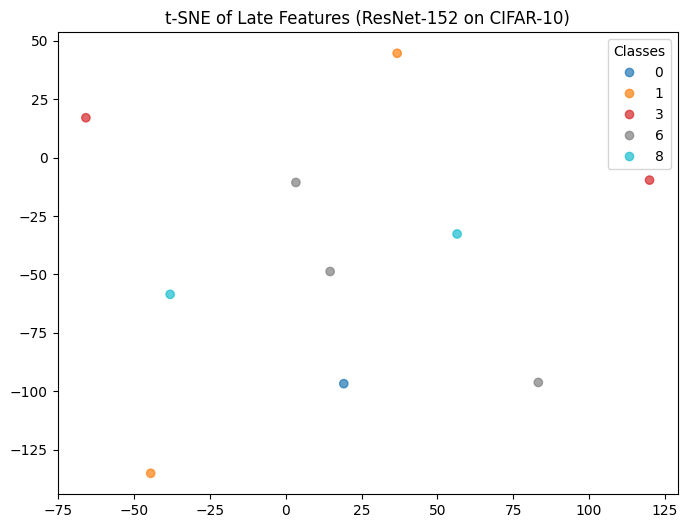

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


images, labels = next(iter(testloader_224))
subset_size = 10
images, labels = images[:subset_size].to(device), labels[:subset_size].to(device)



_ = base_model(images)

early_feats = torch.cat(features["early"], dim=0).numpy()
middle_feats = torch.cat(features["middle"], dim=0).numpy()
late_feats = torch.cat(features["late"], dim=0).numpy()
features.clear()

tsne = TSNE(n_components=2, random_state=42, init="pca", perplexity=5)
late_2d = tsne.fit_transform(late_feats)
plt.figure(figsize=(8,6))
scatter = plt.scatter(late_2d[:,0], late_2d[:,1], c=labels.cpu(), cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of Late Features (ResNet-152 on CIFAR-10)")
plt.show()

#**Task 4. Transfer Learning and Generalization**

##***a. Finetune ResNet152 on CIFAR-10 Dataset***

###a.a Freeze Backbone

In [ ]:
resnet152_CIFAR10 = copy(base_model)

In [ ]:
num_classes = 10
resnet152_base_model.fc = nn.Linear(resnet152_CIFAR10.fc.in_features, num_classes).to(device)

for p in resnet152_CIFAR10.parameters():
    p.requires_grad = False
for p in resnet152_CIFAR10.fc.parameters():
    p.requires_grad = True

def _set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
resnet152_CIFAR10.apply(_set_bn_eval)

###a.b Preparing Data with Upsampling

In [ ]:
transform_train_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_test_224 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_224 = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train_224)
trainloader_224 = torch.utils.data.DataLoader(
    trainset_224, batch_size=16, shuffle=True, num_workers=2)

testset_224 = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test_224)
testloader_224 = torch.utils.data.DataLoader(
    testset_224, batch_size=16, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170M/170M [00:15<00:00, 10.7MB/s]


###a.c Defining Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet152_CIFAR10.fc.parameters(), lr=1e-3, weight_decay=1e-4)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

###a.d Training Classification Head on CIFAR-10

In [ ]:
epochs = 5
history = []

resnet152_CIFAR10.to(device)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(resnet152_CIFAR10, trainloader_224, optimizer, criterion, device)
    val_loss, val_acc = evaluate(resnet152_CIFAR10 , testloader_224, criterion, device)

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

Starting epoch 1...
Epoch 01: train_loss=0.7225 train_acc=0.7955 | val_loss=0.4954 val_acc=0.8438
Starting epoch 2...
Epoch 02: train_loss=0.4625 train_acc=0.8511 | val_loss=0.4384 val_acc=0.8585
Starting epoch 3...
Epoch 03: train_loss=0.4253 train_acc=0.8597 | val_loss=0.4182 val_acc=0.8656
Starting epoch 4...
Epoch 04: train_loss=0.4000 train_acc=0.8675 | val_loss=0.4032 val_acc=0.8687
Starting epoch 5...
Epoch 05: train_loss=0.3866 train_acc=0.8723 | val_loss=0.3946 val_acc=0.8728


##***b. Default vs Random Weights***

In [ ]:
model_random_weights = resnet152(weights=None).to(device)

In [ ]:
num_classes = 10
model_random_weights.fc = nn.Linear(model_random_weights.fc.in_features, num_classes).to(device)

for p in model_random_weights.parameters():
    p.requires_grad = False

for p in model_random_weights.fc.parameters():
    p.requires_grad = True

def _set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
model_random_weights.apply(_set_bn_eval)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_random_weights.fc.parameters(), lr=1e-3, weight_decay=1e-4)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

In [ ]:
epochs = 5
history = []

model_random_weights.to(device)
for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(model_random_weights, trainloader_224, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_random_weights , testloader_224, criterion, device)

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

Starting epoch 1...
Epoch 01: train_loss=2.3539 train_acc=0.1281 | val_loss=2.3612 val_acc=0.1310
Starting epoch 2...
Epoch 02: train_loss=2.3280 train_acc=0.1404 | val_loss=2.3417 val_acc=0.1446
Starting epoch 3...
Epoch 03: train_loss=2.2921 train_acc=0.1514 | val_loss=2.3464 val_acc=0.1232
Starting epoch 4...
Epoch 04: train_loss=2.2887 train_acc=0.1563 | val_loss=2.2813 val_acc=0.1439
Starting epoch 5...
Epoch 05: train_loss=2.2719 train_acc=0.1641 | val_loss=2.3114 val_acc=0.1317


##**C. Full Finetuning**


###Full Finetuning with Default Weights

In [6]:
model_default_weights_fullfinetune = copy(base_model)

for p in model_default_weights_fullfinetune.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_default_weights_fullfinetune.parameters()),
                            lr=1e-4, weight_decay=1e-4)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [7]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

In [9]:
epochs = 3
history = []

# Delete previous models to free up memory
del model_no_skip
del model_random_weights
del resnet152_CIFAR10

model_default_weights_fullfinetune.to(device)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(model_default_weights_fullfinetune, trainloader_224, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_default_weights_fullfinetune , testloader_224, criterion, device)

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

Starting epoch 1...


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 26.12 MiB is free. Process 2131 has 14.71 GiB memory in use. Of the allocated memory 14.42 GiB is allocated by PyTorch, and 183.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

###Full Finetuning with Random Weights

In [ ]:
model_random_weights_fullfinetune = resnet152(weights=None).to(device)

for p in model_random_weights_fullfinetune.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_random_weights_fullfinetune.parameters()),
                            lr=1e-4, weight_decay=1e-4)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy(logits, targets) * bs
        n += bs
    return running_loss / n, running_acc / n

In [ ]:
epochs = 3
history = []

model_random_weights_fullfinetune.to(device)

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch}...")
    train_loss, train_acc = train_one_epoch(model_random_weights_fullfinetune, trainloader_224, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_random_weights_fullfinetune   , testloader_224, criterion, device)

    history.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "train_acc":  round(train_acc, 4),
        "val_loss":   round(val_loss, 4),
        "val_acc":    round(val_acc, 4),
    })
    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

Starting epoch 1...
Epoch 01: train_loss=1.8532 train_acc=0.3242 | val_loss=1.5563 val_acc=0.4383
Starting epoch 2...
